In [1]:
!pip install pystan
!pip install fbprophet
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 33.8 MB/s 
     |████████████████████████████████| 9.8 MB 54.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
#Importing libraries
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
%matplotlib inline
import matplotlib as mpl
from fbprophet import Prophet
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error


In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv       dataframe_flow_variable_60min.csv
dataframe_dma_flow_60min.csv    DMA_225.csv
dataframe_flow_1D.csv           DMA_468.csv
dataframe_flow_variable_1D.csv  persistence_results.pkl


In [12]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_468.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')

In [13]:

data.rename( columns={'Flow':'DMA_468','Date-time':'Date_time'}, inplace=True )
data_DMA468 = data[['Date_time','DMA_468']]

In [14]:
figure = px.line(data_DMA468,x="Date_time",y="DMA_468",title="DMA_468 with slider")
figure.update_xaxes(rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="12m",
                     step="month",
                     stepmode="backward"),
                dict(count=2,
                     label="8m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="4m",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    )
figure.show()

In [19]:
data_DMA468_indexed = data_DMA468.set_index('Date_time')
hourly_data = data_DMA468_indexed.resample('h').sum()

# Stationarity check

In [20]:
#Statistical information
hourly_data.describe()

,DMA_468
count,8760.000000
mean,3.313481
std,1.836744
min,0.000000
25%,1.477750
50%,3.589000
75%,4.700000
max,19.456000


<Figure size 1584x720 with 0 Axes>

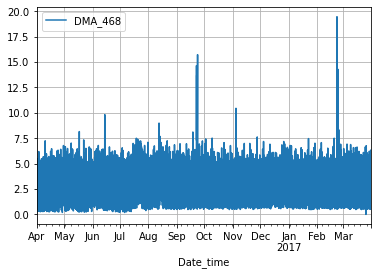

<Figure size 1584x720 with 0 Axes>

In [21]:
# Looking at plots
DMA468_df_indexed = hourly_data[['DMA_468']]
DMA468_df_indexed.plot(grid=True)
plt.figure(figsize=(22,10))

In [22]:

# Augmented Dickey-Fuller test
#Null Hypothesis (H0): If failed to be rejected, meaning it is non-stationary. It has some time dependent structure.
#Alternate Hypothesis (H1): The null hypothesis is rejected;  meaning it is stationary. It does not have time-dependent structure.

ADF_Check_Stationary = adfuller(hourly_data)
print('ADF Statistic: %f' % ADF_Check_Stationary[0])
print('p-value: %f' % ADF_Check_Stationary[1])
print('Critical Values:')
for key, value in ADF_Check_Stationary[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.137910
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Observation :

1.The ADF statistic value of -11. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

2.p value - 0.000058 < 0.05 ; Data is stationary

In [23]:
#Kwiatkowski-Phillips-Schmidt-Shin test
#Null Hypothesis (H0): stationary.
#Alternate Hypothesis (H1): non-stationary

KPSS_Check_Stationary = kpss(hourly_data)
KPSS_Check_Stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2003: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(0.1107091479570847,
 0.1,
 9,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Observation :

1.The ADF statistic value of 0.11. The positive value is statistic, and hence we have a stationary dataset.



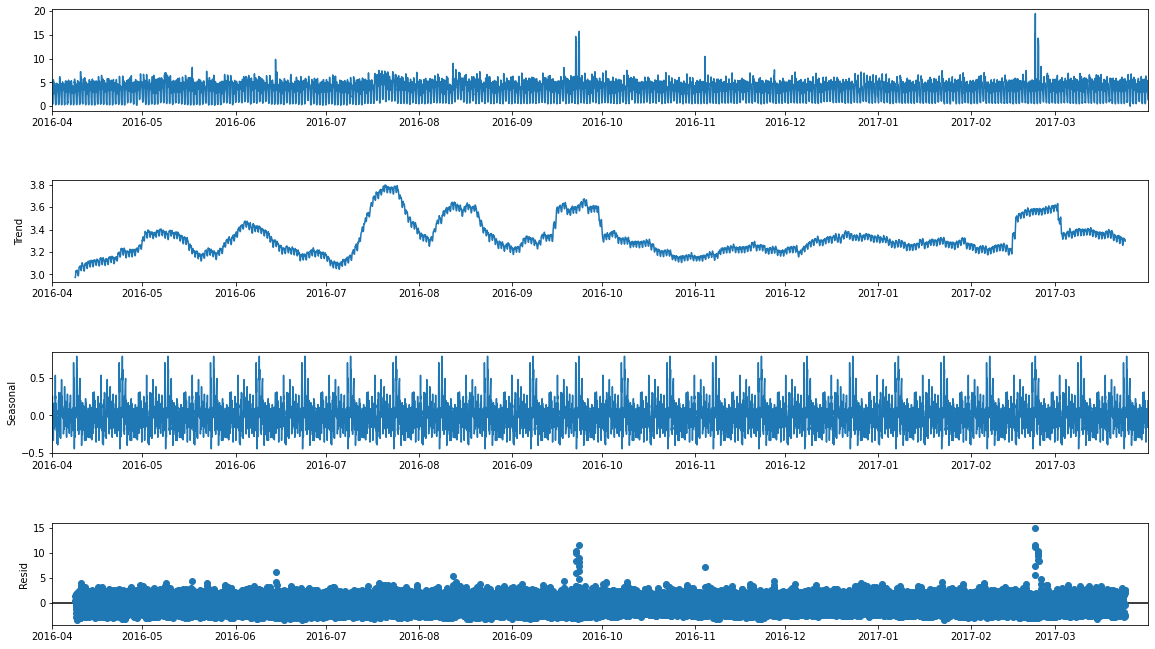

In [24]:
res=sm.tsa.seasonal_decompose(hourly_data,period=365)
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(18)
plt.show()

In [28]:
# Making hourly data 
#hourly_data = data_DMA225_indexed.resample('h').sum()
#Resetting index
hourly_data_index = hourly_data.reset_index()
#Renaming columns
hourly_data_index = hourly_data_index.rename(columns= {'Date_time': 'ds', 'DMA_468':'y'})
hourly_data_index.shape

(8760, 2)

In [31]:
#Train and test split
split = 1059
train = hourly_data_index[:-1059]
test = hourly_data_index[-1059:]

In [32]:
train.shape

(7701, 2)

In [33]:
test.shape

(1059, 2)

In [34]:
#Instatntiate model
model = Prophet()
#Train
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [35]:
future = model.make_future_dataframe(periods=1059,freq = '1H')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8755,2017-03-31 19:00:00,4.686014,3.641943,5.742450
8756,2017-03-31 20:00:00,3.960208,2.808946,5.017452
8757,2017-03-31 21:00:00,2.967200,1.965013,4.048286
8758,2017-03-31 22:00:00,2.034152,0.884300,3.071126
8759,2017-03-31 23:00:00,1.375356,0.374972,2.436321


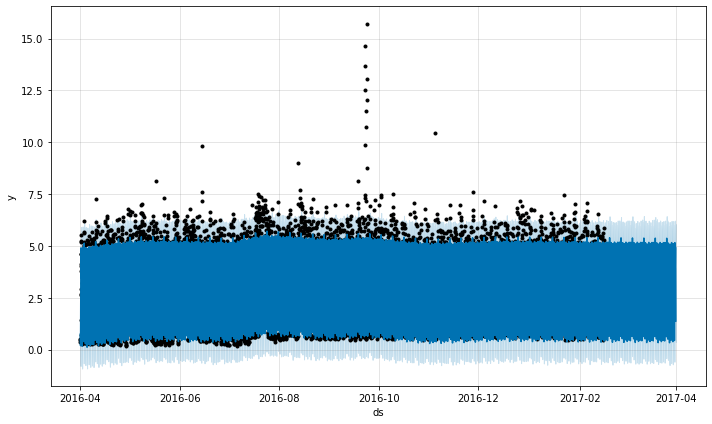

In [37]:
model.plot(forecast)
plt.show()

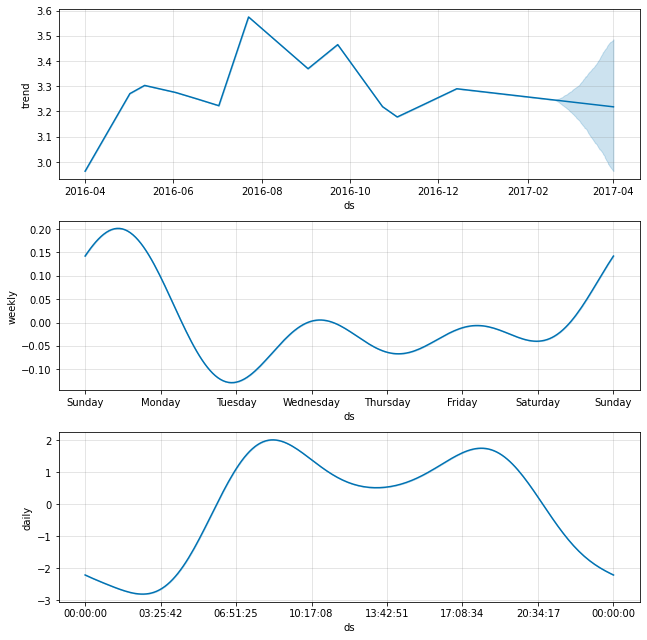

In [38]:
model.plot_components(forecast)
plt.show()

In [39]:
forecast.shape

(8760, 19)

In [40]:
pred = forecast[['ds', 'yhat']]
pred = pred[-1059:]
pred

,ds,yhat
7701,2017-02-15 21:00:00,2.978581
7702,2017-02-15 22:00:00,2.043671
7703,2017-02-15 23:00:00,1.382935
7704,2017-02-16 00:00:00,0.978184
7705,2017-02-16 01:00:00,0.681325
...,...,...
8755,2017-03-31 19:00:00,4.686014
8756,2017-03-31 20:00:00,3.960208
8757,2017-03-31 21:00:00,2.967200
8758,2017-03-31 22:00:00,2.034152


In [41]:
test.head(2)

,ds,y
7701,2017-02-15 21:00:00,3.411
7702,2017-02-15 22:00:00,2.800


In [42]:
# Making final df of original and predicted value
#fp = forecast_prediction[['ds', 'yhat']]
fd1=pd.merge(test, pred, on="ds")
fd1

,ds,y,yhat
0,2017-02-15 21:00:00,3.411,2.978581
1,2017-02-15 22:00:00,2.800,2.043671
2,2017-02-15 23:00:00,1.755,1.382935
3,2017-02-16 00:00:00,1.011,0.978184
4,2017-02-16 01:00:00,0.822,0.681325
...,...,...,...
1054,2017-03-31 19:00:00,4.711,4.686014
1055,2017-03-31 20:00:00,3.211,3.960208
1056,2017-03-31 21:00:00,2.667,2.967200
1057,2017-03-31 22:00:00,2.244,2.034152


In [43]:
#Calculate rmse
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(fd1.y,fd1.yhat))
rmse = round(rmse, 3)
print (" The root mean square vaue on testset: ",rmse)

 The root mean square vaue on testset:  1.2


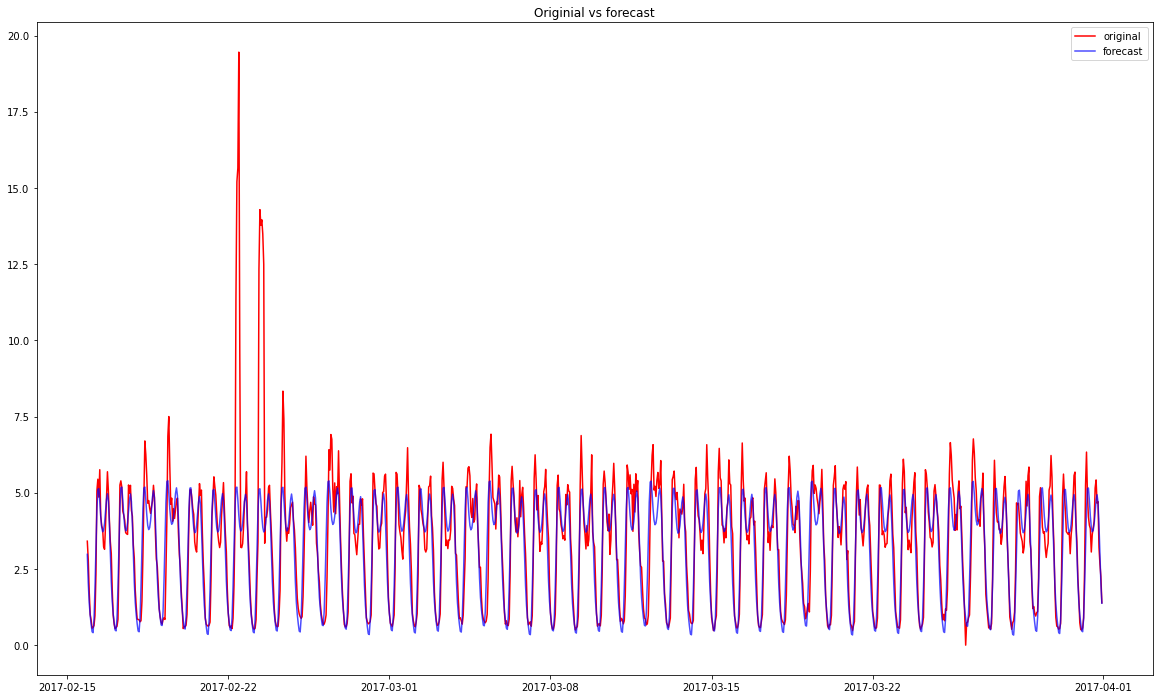

In [44]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(fd1.ds, fd1.y, color='red', label='original')
plt.plot(fd1.ds, fd1.yhat, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()